## Flower Classification

A simple-ish image clasification demonstration of using convolutional neural networks to classify different species of flowers. 

In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#### Use Tensorflow's data generators to apply image augmentations and normalization of pixels

In [2]:
# Train data generator 
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    horizontal_flip=True,
    validation_split=0.2
)

# Validation data generator 
val_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

# Test data generator 
test_datagen = ImageDataGenerator(rescale=1./255)

# Train Generator
train_generator = train_datagen.flow_from_directory(
    'flowers/train',
    target_size=(320,320),
    batch_size=32,
    class_mode='categorical',
    subset='training', 
    seed=123
)

# Validation Generator 
validation_generator = val_datagen.flow_from_directory(
    'flowers/train',  
    target_size=(320,320),  
    batch_size=32,
    class_mode='categorical',
    subset='validation',  
    seed=123
)

# Test Generator 
test_generator = test_datagen.flow_from_directory(
    'flowers/test',
    target_size=(320,320),
    batch_size=32,
    class_mode='categorical'
)

Found 3171 images belonging to 5 classes.
Found 791 images belonging to 5 classes.
Found 327 images belonging to 5 classes.


#### Now lets prepare the model

We will import the VGG16 model for transfer learning

In [3]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [4]:
base_model = VGG16()
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [5]:
base_model = VGG16(include_top=False, input_shape=(320,320,3))
base_model.trainable = False
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 320, 320, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 320, 320, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 320, 320, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 160, 160, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 160, 160, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 160, 160, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 80, 80, 128)       0     

In [6]:
model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(256, activation='relu'))
model.add(Dropout(.2))
model.add(Dense(5, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 10, 10, 512)       14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 256)               131328    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 5)                 1285      
                                                                 
Total params: 14,847,301
Trainable params: 132,613
Non-trainable params: 14,714,688
______________________________________

In [7]:
model.compile(
        optimizer=Adam(learning_rate=0.00001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
)

In [8]:
import os
checkpoint_path = "training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

In [9]:
checkpoint = ModelCheckpoint(filepath=checkpoint_path,
                             save_best_only=True,
                             save_weights_only=True,
                             monitor='val_accuracy',
                             mode='max',
                             verbose=1)

early_stopping = EarlyStopping(patience=3, mode='max', verbose=1)

lr_adjust = ReduceLROnPlateau(monitor='val_loss', patience=1, verbose=1, factor=0.5)

In [10]:
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=validation_generator,
    callbacks=[lr_adjust, checkpoint, early_stopping]
)

Epoch 1/20
100/100 [==============================] - ETA: 0s - loss: 1.6344 - accuracy: 0.2315
Epoch 1: val_accuracy improved from -inf to 0.30594, saving model to training_1\cp.ckpt
100/100 [==============================] - 564s 6s/step - loss: 1.6344 - accuracy: 0.2315 - val_loss: 1.5816 - val_accuracy: 0.3059 - lr: 1.0000e-05
Epoch 2/20
100/100 [==============================] - ETA: 0s - loss: 1.5976 - accuracy: 0.2703
Epoch 2: val_accuracy improved from 0.30594 to 0.40076, saving model to training_1\cp.ckpt
100/100 [==============================] - 563s 6s/step - loss: 1.5976 - accuracy: 0.2703 - val_loss: 1.5514 - val_accuracy: 0.4008 - lr: 1.0000e-05
Epoch 3/20
100/100 [==============================] - ETA: 0s - loss: 1.5716 - accuracy: 0.2841
Epoch 3: val_accuracy improved from 0.40076 to 0.43489, saving model to training_1\cp.ckpt
100/100 [==============================] - 563s 6s/step - loss: 1.5716 - accuracy: 0.2841 - val_loss: 1.5258 - val_accuracy: 0.4349 - lr: 1.0000

In [25]:
import matplotlib.pyplot as plt

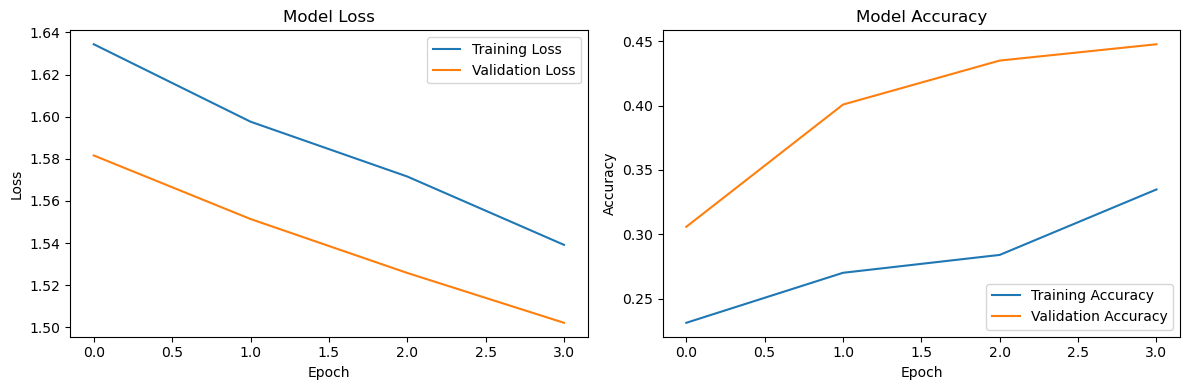

In [26]:
loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.plot(accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.tight_layout()
plt.show()

In [11]:
base_model.trainable = True
for layer in base_model.layers[:-4]:
    layer.trainable = False

In [13]:
for layer in base_model.layers:
    print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x00000201B83C77F0> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x00000201BA545EA0> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x00000201BA545CF0> False
<keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x00000201BA544D90> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x00000201BA545D80> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x00000201B83E9210> False
<keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x00000201BA5C7F70> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x00000201BA5C69B0> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x00000201BA607F10> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x00000201BA607C70> False
<keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x00000201BA604A60> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x00000201BA604E50> False
<keras.layers.convolutional.conv2d.Conv2D object

In [15]:
model2 = Sequential()
model2.add(base_model)
model2.add(GlobalAveragePooling2D())
model2.add(Dense(256, activation='relu'))
model2.add(Dropout(.2))
model2.add(Dense(5, activation='softmax'))
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 10, 10, 512)       14714688  
                                                                 
 global_average_pooling2d_1   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_2 (Dense)             (None, 256)               131328    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 5)                 1285      
                                                                 
Total params: 14,847,301
Trainable params: 7,212,037
Non-trainable params: 7,635,264
___________________________________

In [16]:
model2.compile(
        optimizer=Adam(learning_rate=0.00001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
)

In [20]:
checkpoint_path = "training_2/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

In [21]:
checkpoint = ModelCheckpoint(filepath=checkpoint_path,
                             save_best_only=True,
                             save_weights_only=True,
                             monitor='val_accuracy',
                             mode='max',
                             verbose=1)

early_stopping = EarlyStopping(patience=3, mode='max', verbose=1)

lr_adjust = ReduceLROnPlateau(monitor='val_loss', patience=1, verbose=1, factor=0.5)

In [22]:
history2 = model2.fit(
    train_generator,
    epochs=20,
    validation_data=validation_generator,
    callbacks=[lr_adjust, checkpoint, early_stopping]
)

Epoch 1/20
100/100 [==============================] - ETA: 0s - loss: 1.2671 - accuracy: 0.4803
Epoch 1: val_accuracy improved from -inf to 0.73325, saving model to training_2\cp.ckpt
100/100 [==============================] - 669s 7s/step - loss: 1.2671 - accuracy: 0.4803 - val_loss: 0.8036 - val_accuracy: 0.7332 - lr: 1.0000e-05
Epoch 2/20
100/100 [==============================] - ETA: 0s - loss: 0.7601 - accuracy: 0.7155
Epoch 2: val_accuracy improved from 0.73325 to 0.79772, saving model to training_2\cp.ckpt
100/100 [==============================] - 668s 7s/step - loss: 0.7601 - accuracy: 0.7155 - val_loss: 0.5759 - val_accuracy: 0.7977 - lr: 1.0000e-05
Epoch 3/20
100/100 [==============================] - ETA: 0s - loss: 0.5910 - accuracy: 0.7827
Epoch 3: val_accuracy improved from 0.79772 to 0.82933, saving model to training_2\cp.ckpt
100/100 [==============================] - 672s 7s/step - loss: 0.5910 - accuracy: 0.7827 - val_loss: 0.4818 - val_accuracy: 0.8293 - lr: 1.0000

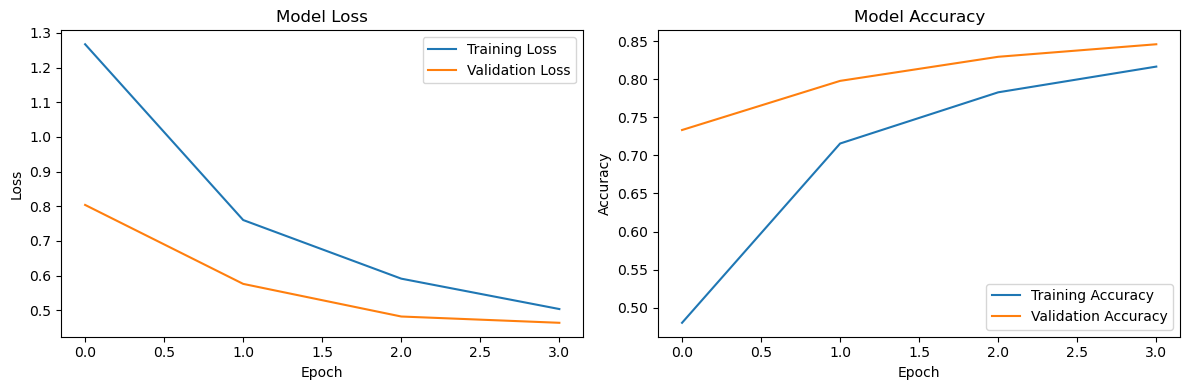

In [24]:
loss2 = history2.history['loss']
val_loss2 = history2.history['val_loss']
accuracy2 = history2.history['accuracy']
val_accuracy2 = history2.history['val_accuracy']

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(loss2, label='Training Loss')
plt.plot(val_loss2, label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.plot(accuracy2, label='Training Accuracy')
plt.plot(val_accuracy2, label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.tight_layout()
plt.show()